# **Detecting Alzheimer’s with Enhanced Slice Selection & ViT**  
### *Second Improvement Deliverable*

---

## **Group Members**
- **Sheraz Waseem** – *26100026*  
- **Umair Amir** – *26100148*  

---

## **Dataset: OASIS-2**  

The **OASIS-2** dataset is a longitudinal collection of brain MRI scans used to study aging and Alzheimer’s Disease progression.  

**Key Details:**
- **Subjects:** 150 elderly individuals aged 60–96  
- **Scans:** Multiple T1-weighted scans per subject  
- **Labels:** Clinical Dementia Rating (CDR), ranging from 0 (Non-demented) to 2 (Moderate Dementia)  

---

#  Dementia Stage Classification with SE Module & Vision Transformer on OASIS-2

This notebook demonstrates the **second improvement** in our deep learning pipeline for classifying **Alzheimer’s Disease progression** using structural brain MRI scans from the **OASIS-2** dataset.

In this enhanced approach:

- We **train our Enhanced Squeeze-and-Excitation (SE) module** as part of a unified pipeline to identify the most relevant brain slices from the 3D volume.
- We then use a **Vision Transformer (ViT)** to perform **multiclass classification** over the distinct stages of Alzheimer's Disease, categorized using the **Clinical Dementia Rating (CDR)** scale.

The model predicts one of the following stages:
- **CDR = 0**: No dementia  
- **CDR = 0.5**: Very mild dementia  
- **CDR = 1**: Mild dementia  
- **CDR = 2**: Moderate dementia

By combining the **SE-based slice selection** with **ViT's global attention**, the model learns both **where to look** and **how to interpret** the most informative parts of the brain for accurate dementia staging.

---

## Dataset: OASIS-2 Longitudinal MRI

- The dataset contains structural T1-weighted MRI scans stored in **Analyze/NIfTI** format (`.hdr/.img` pairs).
- Each subject has a 3D brain scan with a corresponding **CDR (Clinical Dementia Rating)** score.
- The CDR scores range over:
  - `0`: No Dementia
  - `0.5`: Very Mild Dementia
  - `1`: Mild Dementia
  - `2`: Moderate or Severe Dementia
- We convert these to **class indices**: `0 → 0`, `0.5 → 1`, `1 → 2`, `2+ → 3`.

---

## Data Preprocessing

- Each `.hdr/.img` volume is loaded using the **nibabel** library.
- Slices are normalized to have intensity values between `[0, 1]`.
- MRI volumes are converted into PyTorch tensors with shape: `(D, 1, H, W)` where `D` is the number of slices.
- Labels are read from an Excel file containing patient metadata and matched by subject ID.

### Custom Dataset: `OasisVolumeDataset`

- Loads each volume and its corresponding label.
- Performs:
  - Intensity normalization
  - Resizing (optional)
  - Tensor conversion
- Returns a dictionary: `{"volume": volume_tensor, "label": label_tensor}`.

---

## Architecture Overview

We design a two-stage architecture:

### 1. SliceSelector Module (Enhanced SE Block)

- **Input shape**: `(B, D, 1, H, W)` — batch of 3D volumes with depth `D`.
- Applies a **Squeeze-and-Excitation** mechanism over the depth dimension.
- Learns **channel-wise attention weights** that indicate how important each slice is.
- Selects the **top-k most relevant slices** based on these learned weights.
- Selected slices are stacked to create a **3-channel 2D image** of shape `(3, 224, 224)`.

### 2. Vision Transformer (ViT)

- A pretrained `ViT-B/16` model from Hugging Face (`google/vit-base-patch16-224-in21k`).
- Input shape: `(3, 224, 224)` image constructed by the SliceSelector.
- We fine-tune only the classification head on our dementia classes.
- **Output**: logits of shape `(B, 4)` representing the 4 CDR classes.

---

### Forward Flow:

volume → SliceSelector → (B, 3, 224, 224) → Vision Transformer → (B, 4) logits

### Training Strategy

- **Loss function**: `CrossEntropyLoss` over 4 CDR classes.
- **Optimizer**: `Adam` or `AdamW` (especially suited for ViT-based models).
- **Learning rate scheduler**: Optional — can use cosine annealing or step decay.
- **Batch size**: Depends on available GPU memory (typically 4–8).
- **Regularization**: 
  - **Early stopping** based on validation loss or F1-score.
  - **Model checkpointing** to save the best-performing model.

---

## Stratified Train-Validation Split

- Performed using `StratifiedShuffleSplit` from `sklearn.model_selection`.
- Ensures **class distribution balance** across train and validation sets.
- **Rare classes** (e.g. `CDR=2` with only one sample) are excluded to prevent data leakage and training instability.

---

## Evaluation Metrics

- **Accuracy**: Percentage of correctly classified samples.
- **Macro F1-score**: Treats all classes equally, regardless of support.
- **Confusion matrix**: Visual tool to examine model performance across CDR categories.
---

## Advantages of This Approach

- **Efficiency**: Avoids costly 3D CNNs by projecting to informative 2D slices.
- **Explainability**: The `SliceSelector` module highlights the most discriminative regions in the brain.
- **Transfer Learning**: Utilizes pretrained ViT encoders from large-scale natural image datasets, accelerating convergence.
- **Adaptability**: Easily extendable to other volumetric medical imaging datasets beyond dementia (e.g. tumors, stroke).


## Connecting to Google Drive to Access Dataset

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Extracting dataset zip file

In [3]:
import tarfile

file_path = '/content/drive/MyDrive/KerasModel/OAS2_RAW_PART1.tar.gz'
extract_path = '/content/oasis_data'

with tarfile.open(file_path, 'r:gz') as tar:
    tar.extractall(path=extract_path)

print("Extraction complete.")

Extraction complete.


## Removing the Converted Classes

In [ ]:
import os, shutil, pandas as pd

XL_PATH   = "/content/drive/MyDrive/KerasModel/oasis_longitudinal_demographics-8d83e569fa2e2d30.xlsx"
DATA_ROOT = "/content/oasis_data/OAS2_RAW_PART1"
TRASH_DIR = "/content/converted_scans_backup" 

df = pd.read_excel(XL_PATH)

converted_ids = df.loc[df["Group"].eq("Converted"), "MRI ID"].unique().tolist()
print(f"Found {len(converted_ids)} converted visits")

os.makedirs(TRASH_DIR, exist_ok=True)

for mri_id in converted_ids:
    src = os.path.join(DATA_ROOT, mri_id)  
    if not os.path.isdir(src):
        print(f"[WARN] {src} not found, skipping")
        continue

    dst = os.path.join(TRASH_DIR, mri_id)
    shutil.move(src, dst)                 
    
    print(f"✓ removed {mri_id}")

print("Done!")

Found 37 converted visits
✓ removed OAS2_0018_MR1
✓ removed OAS2_0018_MR3
✓ removed OAS2_0018_MR4
✓ removed OAS2_0020_MR1
✓ removed OAS2_0020_MR2
✓ removed OAS2_0020_MR3
✓ removed OAS2_0031_MR1
✓ removed OAS2_0031_MR2
✓ removed OAS2_0031_MR3
✓ removed OAS2_0041_MR1
✓ removed OAS2_0041_MR2
✓ removed OAS2_0041_MR3
✓ removed OAS2_0054_MR1
✓ removed OAS2_0054_MR2
✓ removed OAS2_0092_MR1
✓ removed OAS2_0092_MR2
[WARN] /content/oasis_data/OAS2_RAW_PART1/OAS2_0103_MR1 not found, skipping
[WARN] /content/oasis_data/OAS2_RAW_PART1/OAS2_0103_MR2 not found, skipping
[WARN] /content/oasis_data/OAS2_RAW_PART1/OAS2_0103_MR3 not found, skipping
[WARN] /content/oasis_data/OAS2_RAW_PART1/OAS2_0118_MR1 not found, skipping
[WARN] /content/oasis_data/OAS2_RAW_PART1/OAS2_0118_MR2 not found, skipping
[WARN] /content/oasis_data/OAS2_RAW_PART1/OAS2_0127_MR1 not found, skipping
[WARN] /content/oasis_data/OAS2_RAW_PART1/OAS2_0127_MR2 not found, skipping
[WARN] /content/oasis_data/OAS2_RAW_PART1/OAS2_0127_MR3 no

  0%|          | 0/373 [00:00<?, ?it/s]

Usable scans for 4-class: 193
4-class label distribution:
 label
0    110
1     58
2     24
3      1
Name: count, dtype: int64
max depth = 256
Classes with only 1 member: [3]
DataFrame shape (all): (193, 2)
DataFrame shape (rare classes): (1, 2)
DataFrame shape (common classes): (192, 2)
154 train | 39 val

Train label distribution:
label
0    88
1    46
2    19
3     1
Name: count, dtype: int64

Validation label distribution:
label
0    22
1    12
2     5
Name: count, dtype: int64

Note: Samples from rare classes (with only 1 member) were assigned exclusively to the training set.
Therefore, these classes will not appear in the validation set's label distribution or confusion matrix.


Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.186200,1.117943,0.564103,0.406894
2,1.017200,1.064559,0.564103,0.406894
3,0.949600,1.043868,0.564103,0.406894
4,0.944500,1.061179,0.615385,0.508599
5,0.864300,1.015971,0.589744,0.461012
6,0.803100,1.017119,0.564103,0.445521
7,0.760800,1.009301,0.564103,0.445521
8,0.718900,1.016213,0.589744,0.537053
9,0.684000,0.992796,0.589744,0.511528
10,0.658300,0.999517,0.615385,0.558297


Train 4-class accuracy : 0.805
Train 4-class weighted-F1: 0.747


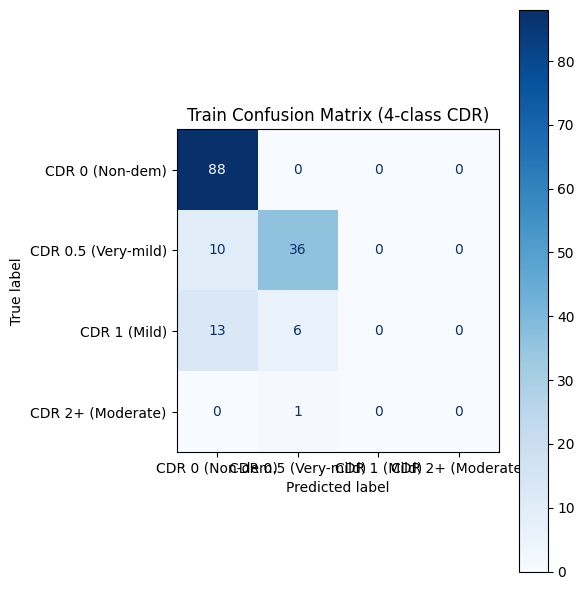

Validation 4-class accuracy : 0.641
Validation 4-class weighted-F1: 0.580


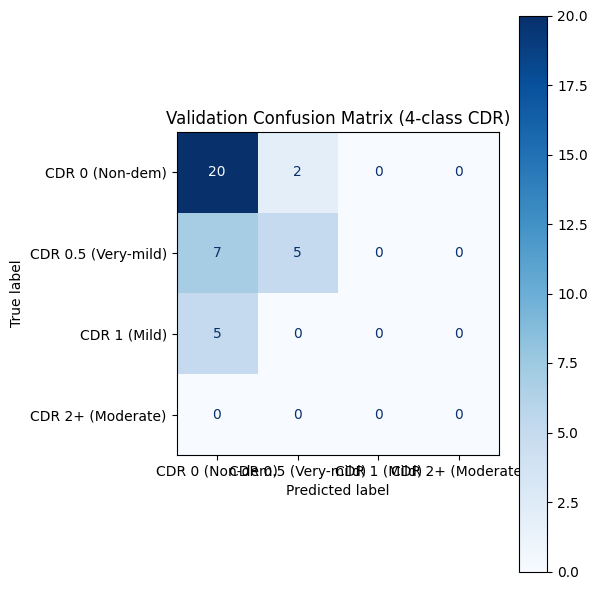

In [ ]:

!pip -q install -U "transformers>=4.41.0" "huggingface_hub>=0.23.0" accelerate \
                    nibabel pandas scikit-learn tqdm pillow


import os
import json
import numpy as np
import pandas as pd
import nibabel as nib
import torch
from PIL import Image
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
import torchvision.transforms as T
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
import pandas as pd 
from transformers import (
    ViTConfig,
    ViTForImageClassification,
    ViTImageProcessor,
    TrainingArguments,
    Trainer,
    DefaultDataCollator,
)
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np   

EXCEL = "/content/drive/MyDrive/KerasModel/oasis_longitudinal_demographics-8d83e569fa2e2d30.xlsx"
ROOT = "/content/oasis_data/OAS2_RAW_PART1"
CFG = "/content/vit_4class_cdr.json"  

cfg_json = {
    "_name_or_path": "google/vit-base-patch16-224-in21k",
    "architectures": ["ViTForImageClassification"],
    "image_size": 224,
    "patch_size": 16,
    "hidden_size": 768,
    "num_hidden_layers": 12,
    "num_attention_heads": 12,
    "intermediate_size": 3072,
    "hidden_act": "gelu",
    "initializer_range": 0.02,
    "layer_norm_eps": 1e-12,
    "qkv_bias": True,
    "num_channels": 3,
    "num_labels": 4, 
    "id2label": {"0": "CDR_0", "1": "CDR_0.5", "2": "CDR_1", "3": "CDR_2"},  
    "label2id": {"CDR_0": 0, "CDR_0.5": 1, "CDR_1": 2, "CDR_2": 3},  
}
with open(CFG, "w") as f:
    json.dump(cfg_json, f)


def three_views_rgb(hdr_path):
    """Return a PIL RGB image (224 × 224) built from the middle axial,
    coronal, sagittal slices. Handles 3-D or 4-D NIfTI volumes."""
    vol = nib.load(hdr_path).get_fdata().astype(np.float32)

    vol = np.squeeze(vol)
    if vol.ndim == 4:
        vol = vol[..., 0]
    if vol.ndim != 3:
        raise ValueError(f"Unexpected volume shape {vol.shape}")

    cx, cy, cz = np.array(vol.shape) // 2
    slices = [vol[cx, :, :], vol[:, cy, :], vol[:, :, cz]]

def to_pil(slice2d):
    s_min, s_max = slice2d.min(), slice2d.max()
    if s_max > s_min:
        sl = ((slice2d - s_min) / (s_max - s_min) * 255).astype(np.uint8)
    else:
        sl = np.zeros_like(slice2d, dtype=np.uint8)
    return Image.fromarray(sl).resize((224, 224), Image.BILINEAR)

    triplet = [np.array(to_pil(s)) for s in slices]     
    stacked = np.stack(triplet, axis=-1)                
    return Image.fromarray(stacked)

df = pd.read_excel(EXCEL)

df = df[["MRI ID", "Group", "CDR"]]

def cdr_to_label(cdr):
    if pd.isna(cdr):
        return -1  
    if cdr == 0:
        return 0          
    if cdr == 0.5:
        return 1          
    if cdr == 1:
        return 2          
    if cdr >= 2:  
        return 3          
    return -1  

df["label_4class"] = df["CDR"].apply(cdr_to_label)

df_filtered = df[df["label_4class"] != -1].copy()  

records = []
for _, row in tqdm(df_filtered.iterrows(), total=len(df_filtered)):
    raw_dir = os.path.join(ROOT, row["MRI ID"], "RAW")
    if not os.path.isdir(raw_dir):
        continue
    hdrs = [f for f in sorted(os.listdir(raw_dir)) if f.endswith(".hdr")]
    if hdrs:
        records.append({
            "hdr_path": os.path.join(raw_dir, hdrs[0]),
            "label": row["label_4class"],
        })

clean_df = pd.DataFrame(records)
print("Usable scans for 4-class:", len(clean_df))
print("4-class label distribution:\n", clean_df['label'].value_counts().sort_index())




to_tensor = T.ToTensor()

class OasisVolumeDataset(Dataset):
    def __init__(self, df_subset):
        self.df = df_subset.reset_index(drop=True)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        vol = nib.load(row.hdr_path).get_fdata().astype(np.float32)
        vol = np.squeeze(vol)
        if vol.ndim == 4:
            vol = vol[..., 0]

        rng = np.ptp(vol)
        vol = (vol - vol.min()) / rng if rng > 0 else np.zeros_like(vol)

        vol_t = torch.stack([to_tensor(s) for s in vol], dim=0)
        label = torch.tensor(row.label, dtype=torch.long)

        return {
            "volume": vol_t,
            "labels": label
        }


def volume_depth(path):
    shape = np.squeeze(nib.load(path).shape)
    return shape[0] if len(shape) >= 3 else 0

max_depth = max(volume_depth(p) for p in clean_df.hdr_path)
print("max depth =", max_depth)



class SliceSelector(nn.Module):
    def __init__(self, depth, reduction=4, k=3):
        super().__init__()
        self.k = k
        self.last_indices = None          
        self.fc = nn.Sequential(
            nn.Linear(depth, depth // reduction),
            nn.ReLU(inplace=True),
            nn.Linear(depth // reduction, depth * k)
        )
        self.resize = T.Resize((224, 224), interpolation=T.InterpolationMode.BILINEAR)  

    def forward(self, x):                 
        B, D, _, H, W = x.shape
        x_flat = x.mean(dim=[3, 4]).squeeze(2)       
        attn = self.fc(x_flat).view(B, self.k, D)  
        weights = F.softmax(attn, dim=-1)             

        self.last_indices = torch.argmax(weights.detach(), dim=-1).cpu()

        comps = torch.einsum("bkd,bdhw->bkhw", weights, x.squeeze(2))
        comps = self.resize(comps)           
        return comps    

class VolumeViTClassifier(nn.Module):
    def __init__(self, vit_model, depth):
        super().__init__()
        self.selector = SliceSelector(depth, k=3)
        self.vit = vit_model       

    def forward(self, volume, labels=None):  
        rgb = self.selector(volume)            

        out = self.vit(pixel_values=rgb, labels=labels)  

        return {
            "loss": out.loss,          
            "logits": out.logits        
        }





label_counts = clean_df['label'].value_counts()
rare_classes = label_counts[label_counts == 1].index.tolist()

print(f"Classes with only 1 member: {rare_classes}")

df_rare = clean_df[clean_df['label'].isin(rare_classes)].copy()
df_common = clean_df[~clean_df['label'].isin(rare_classes)].copy()

print(f"DataFrame shape (all): {clean_df.shape}")
print(f"DataFrame shape (rare classes): {df_rare.shape}")
print(f"DataFrame shape (common classes): {df_common.shape}")

train_df_rare = df_rare


if not df_common.empty:
    train_df_common, val_df = train_test_split(
        df_common,
        test_size=0.2, 
        stratify=df_common["label"], 
        random_state=42
    )
    train_df = pd.concat([train_df_rare, train_df_common], ignore_index=True)
else:
    train_df = train_df_rare
    val_df = pd.DataFrame() 

print(len(train_df), "train |", len(val_df), "val")

print("\nTrain label distribution:")
print(train_df['label'].value_counts().sort_index())

print("\nValidation label distribution:")
if not val_df.empty:
    print(val_df['label'].value_counts().sort_index())
else:
    print("Validation set is empty or contains no samples from common classes.")

if len(rare_classes) > 0:
    print("\nNote: Samples from rare classes (with only 1 member) were assigned exclusively to the training set.")
    print("Therefore, these classes will not appear in the validation set's label distribution or confusion matrix.")




config = ViTConfig.from_json_file(CFG)

processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")

train_set = OasisVolumeDataset(train_df)
val_set = OasisVolumeDataset(val_df)


vit = ViTForImageClassification.from_pretrained(
    "google/vit-base-patch16-224-in21k",
    config=config,  
    ignore_mismatched_sizes=True,  
)

model = VolumeViTClassifier(vit_model=vit, depth=max_depth)

def compute_metrics(eval_pred):
   
    logits, labels = eval_pred

    preds = np.argmax(logits, axis=-1)

    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average="weighted"),
    }

args = TrainingArguments(
    output_dir="/content/vit_oasis_4class_ckpts",  
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=12,
    learning_rate=1e-5,
    weight_decay=1e-4,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1", 
    seed=42,
    logging_strategy="epoch",
)

trainer = Trainer(
    model=model,
    args=args,
    data_collator=DefaultDataCollator(),
    train_dataset=train_set,
    eval_dataset=val_set,
    compute_metrics=compute_metrics,
)

trainer.train()



def four_class_eval(split_name, dataset):
 
    out = trainer.predict(dataset)
    logits = out.predictions        
    y_true_4 = out.label_ids        

    y_pred_4 = np.argmax(logits, axis=-1)

    acc = accuracy_score(y_true_4, y_pred_4)
    f1 = f1_score(y_true_4, y_pred_4, average="weighted")  

    print(f"{split_name} 4-class accuracy : {acc:.3f}")
    print(f"{split_name} 4-class weighted-F1: {f1:.3f}")

    cm = confusion_matrix(y_true_4, y_pred_4, labels=[0, 1, 2, 3])
    disp = ConfusionMatrixDisplay(
        cm,
        display_labels=["CDR 0 (Non-dem)", "CDR 0.5 (Very-mild)", "CDR 1 (Mild)", "CDR 2+ (Moderate)"]
    )
    fig, ax = plt.subplots(figsize=(6, 6))  
    disp.plot(ax=ax, cmap="Blues", values_format="d")
    plt.title(f"{split_name} Confusion Matrix (4-class CDR)")  
    plt.tight_layout()
    plt.show()

four_class_eval("Train", train_set)
four_class_eval("Validation", val_set)